In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import folium
import geopandas as gpd

# Importing functions from other scripts
from visualize import * # Importing reusable functions for all visualize plots
from preprocess import * # Importing functions for basic merging and preprocessing data
import os

### **1. Preprocessing**
**Tasks**:
  - Load and inspect the dataset.
  - Clean the dataset.
  - Group data by pickup zone.

In [2]:
## Step 1: Importing nyc taxi data for 2023

# Getting the current working directory
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, "..", "data")  # Adjust path as needed
print("Script Directory:", script_dir)
print("Data Directory:", data_dir)

# Fuction for preprocessing to merge parquets
data = merge_parquets(data_dir)

Script Directory: /Users/dh/Desktop/DS1007_FinalProject-main/code
Data Directory: /Users/dh/Desktop/DS1007_FinalProject-main/code/../data


In [3]:
## Step 2: Inspect the dataset
data.head()

location_data = gpd.read_file('/Users/dh/Desktop/DS1007_FinalProject-main/data/geospatial/taxi_zones.shp')
location_data.head()

location_data['zone'].nunique()
location_data.shape

merged_data = pd.merge(data, location_data, how='left', left_on='PULocationID', right_on="LocationID")
merged_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,Airport_fee,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,2023-06-01 00:08:48,2023-06-01 00:29:41,1.0,3.40,1.0,N,140,238,1,...,33.60,2.5,0.00,140.0,0.047584,0.000114,Lenox Hill East,140.0,Manhattan,"POLYGON ((995735.062 215619.835, 995670.105 21..."
1,1,2023-06-01 00:15:04,2023-06-01 00:25:18,0.0,3.40,1.0,N,50,151,1,...,23.60,2.5,0.00,50.0,0.055748,0.000173,Clinton West,50.0,Manhattan,"POLYGON ((985170.372 221087.389, 985817.17 220..."
2,1,2023-06-01 00:48:24,2023-06-01 01:07:07,1.0,10.20,1.0,N,138,97,1,...,60.05,0.0,1.75,138.0,0.107467,0.000537,LaGuardia Airport,138.0,Queens,"MULTIPOLYGON (((1019904.219 225677.983, 102031..."
3,2,2023-06-01 00:54:03,2023-06-01 01:17:29,3.0,9.83,1.0,N,100,244,1,...,53.28,2.5,0.00,100.0,0.024813,0.000037,Garment District,100.0,Manhattan,"POLYGON ((987770.527 212686.678, 987638.873 21..."
4,2,2023-06-01 00:18:44,2023-06-01 00:27:18,1.0,1.17,1.0,N,137,234,1,...,15.02,2.5,0.00,137.0,0.046108,0.000116,Kips Bay,137.0,Manhattan,"POLYGON ((991954.728 209026.462, 991949.076 20..."


In [4]:
## Step 3: Clean the dataset

# Sampling data to get 30% of the data
sampled_data = sample_dat(data,0.3)

# Drop rows with missing values in the 'zone' column (pickup zone)
merged_data = merged_data.dropna(subset=['zone'])

# Check for missing values in the merged data
missing_locations = merged_data[merged_data['zone'].isnull()]
print(f"Number of rides with missing location info: {len(missing_locations)}")

Number of rides with missing location info: 0


In [5]:
## Step 4: Group data by pickup zone

# Calculate the total pickups and average fare for each zone
pickup_analysis = merged_data.groupby('zone').agg({
    'tpep_pickup_datetime': 'count',  # Count of total pickups
    'fare_amount': 'mean'             # Average fare
}).reset_index()    

# Rename columns for clarity
pickup_analysis.rename(columns={
    'tpep_pickup_datetime': 'total_pickups',
    'fare_amount': 'avg_fare'
}, inplace=True)

Data Grouping:
- Grouped data by `zone` to calculate two key metrics:
- **`total_pickups`**: The number of trips originating from each zone.
- **`avg_fare`**: The average fare for each zone.

### **2. Visualizations**
**Tasks**:
  - Plot trends and distributions to understand the influence of pickup zones on fares.
  - Visualize the top zones with the highest fares.

#### **2.1)** Line Plot: Average Fare by Pickup Zone

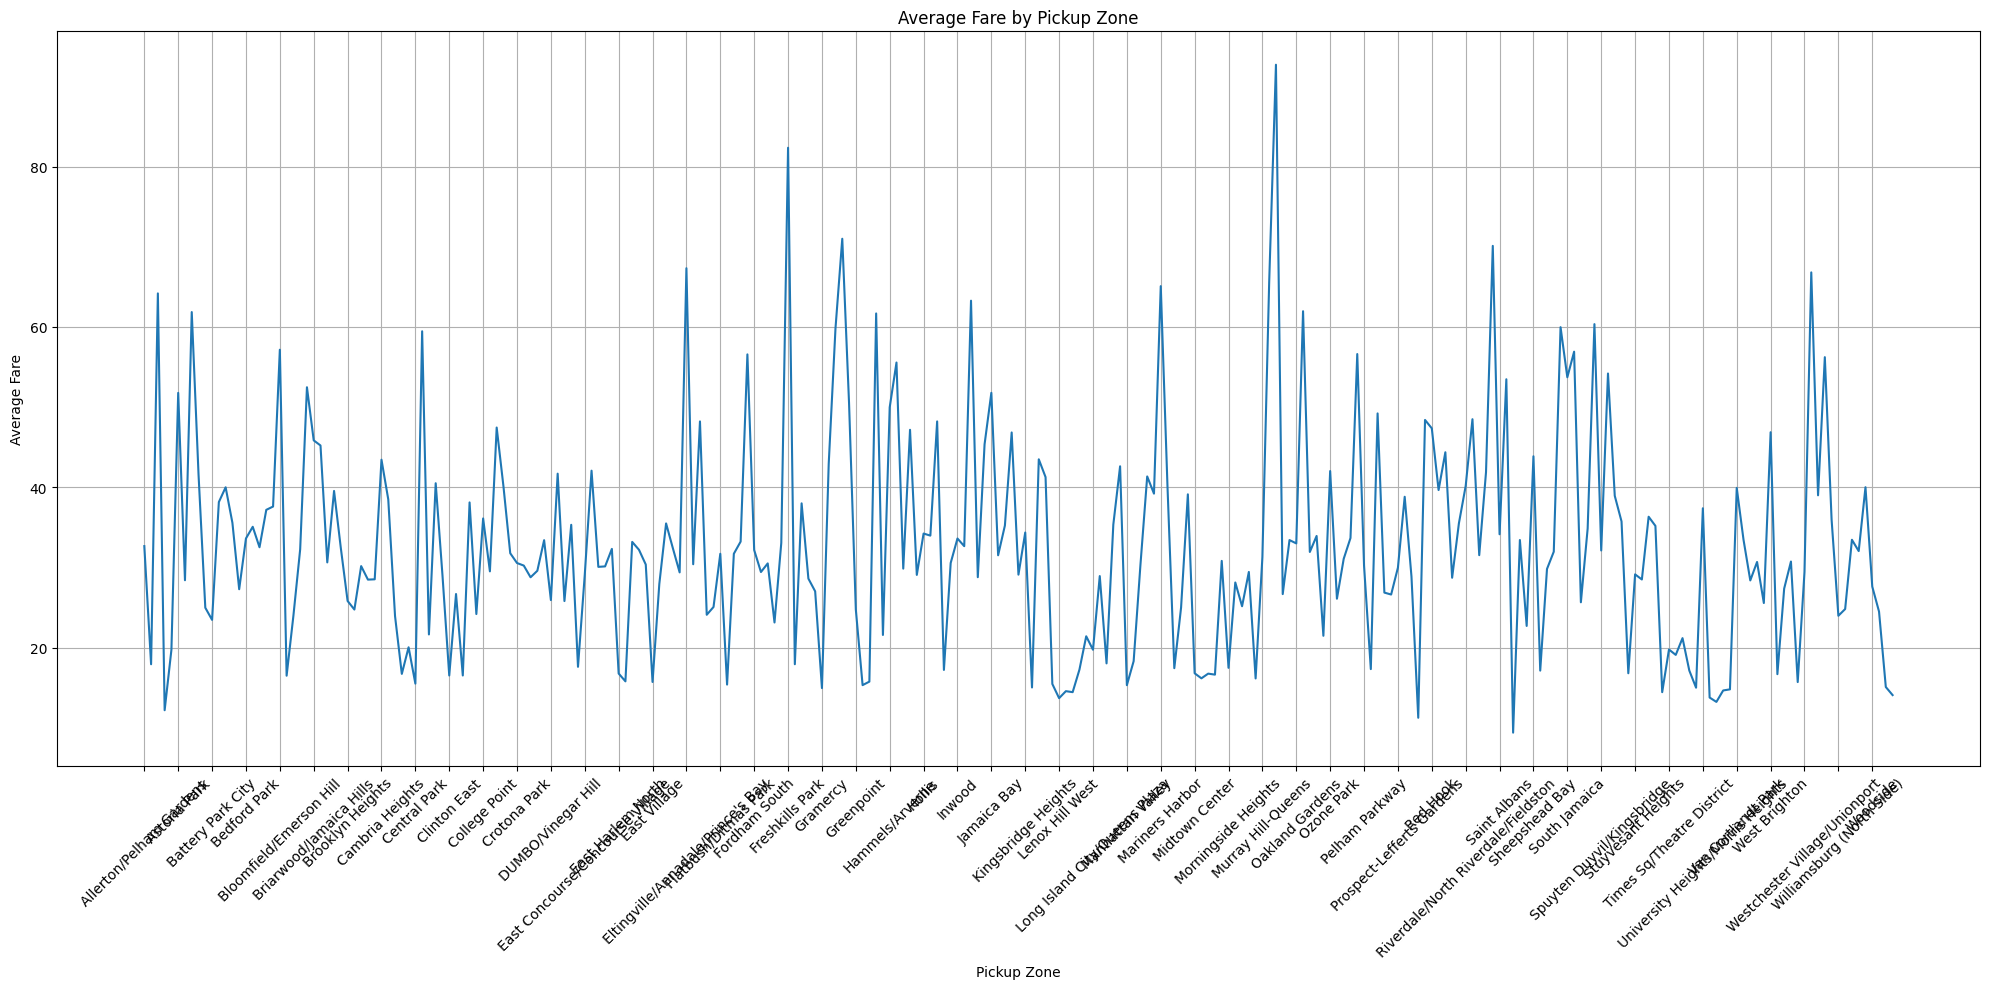

In [6]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=pickup_analysis, x='zone', y='avg_fare')
plt.title('Average Fare by Pickup Zone')
plt.xlabel('Pickup Zone')
plt.ylabel('Average Fare')

# Reduce the number of labels
plt.xticks(ticks=np.arange(0, len(pickup_analysis['zone']), step=5), 
           labels=pickup_analysis['zone'][::5], rotation=45)

plt.grid()
plt.tight_layout()
plt.show()

Line Plot:
- Shows how average fares vary across different pickup zones.
- Helps to identify zones with higher or lower average fares visually.

#### **2.2)** Identify Top 10 Pickup Zones

In [12]:
# Sort by total pickups
pickup_analysis = pickup_analysis.sort_values(by='total_pickups', ascending=False)
print(pickup_analysis.head(10))

                             zone  total_pickups   avg_fare
122                   JFK Airport        1952656  63.263625
232         Upper East Side South        1777161  13.223802
155                Midtown Center        1749732  16.793142
231         Upper East Side North        1585880  13.766141
156                  Midtown East        1342030  16.163635
181  Penn Station/Madison Sq West        1292923  17.313725
132             LaGuardia Airport        1292034  43.481904
225     Times Sq/Theatre District        1254987  19.757901
136           Lincoln Square East        1246290  14.562638
164                   Murray Hill        1121733  16.147146


/var/folders/_1/jwysdl0x60l49x9bpw1hb5q40000gp/T/ipykernel_20140/1598181558.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pickups, x='total_pickups', y='zone', palette='viridis')


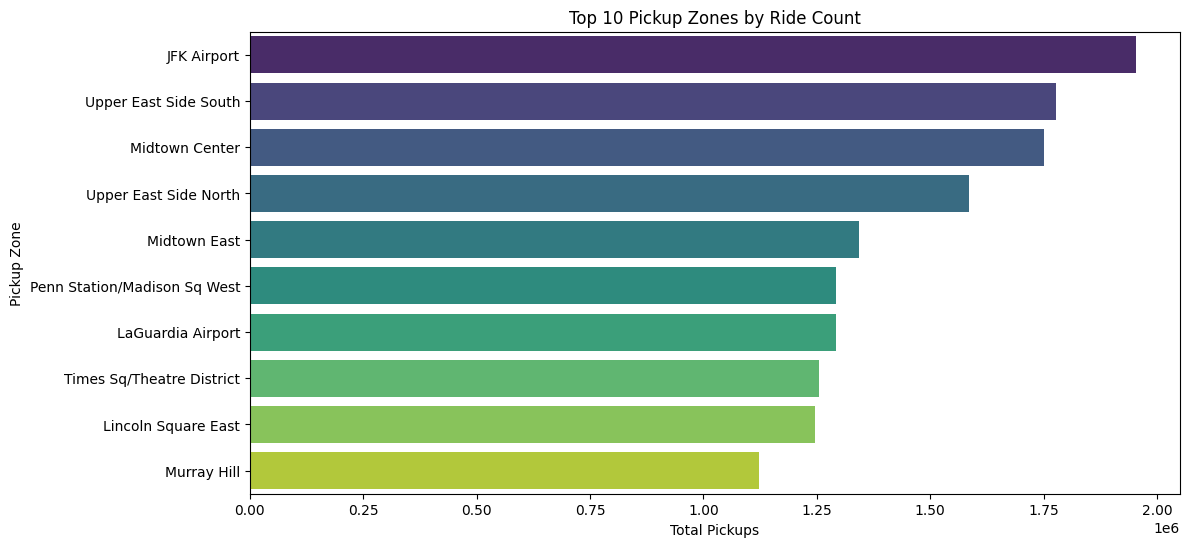

In [13]:
# Plot top 10 pickup zones
top_pickups = pickup_analysis.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_pickups, x='total_pickups', y='zone', palette='viridis')
plt.xlabel('Total Pickups')
plt.ylabel('Pickup Zone')
plt.title('Top 10 Pickup Zones by Ride Count')
plt.show()

#### **2.3)** Identify Top Zones with Highest Average Fares

In [10]:
# Highest average fare per ride （Sorted zones by `avg_fare` to list the top 10 zones with the highest average fares.）
# Sort by average fare for analysis
fare_pickup_analysis = pickup_analysis.sort_values(by='avg_fare', ascending=False)
print("Top 10 Pickup Zones with Highest Average Fares:")
print(fare_pickup_analysis.head(10))

Top 10 Pickup Zones with Highest Average Fares:
                                  zone  total_pickups   avg_fare
167                     Newark Airport           4948  92.693403
95                     Freshkills Park             10  82.340000
103                   Great Kills Park              1  70.990000
199                  Rossville/Woodrow             18  70.100000
80   Eltingville/Annadale/Prince's Bay             15  67.312667
246                        Westerleigh             72  66.793611
166             New Dorp/Midland Beach             30  65.549333
150                    Mariners Harbor             39  65.076410
2                        Arden Heights            387  64.172636
122                        JFK Airport        1952656  63.263625


/var/folders/_1/jwysdl0x60l49x9bpw1hb5q40000gp/T/ipykernel_20140/4282458817.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_fare_pickups_spots, x='avg_fare', y='zone', palette='viridis')


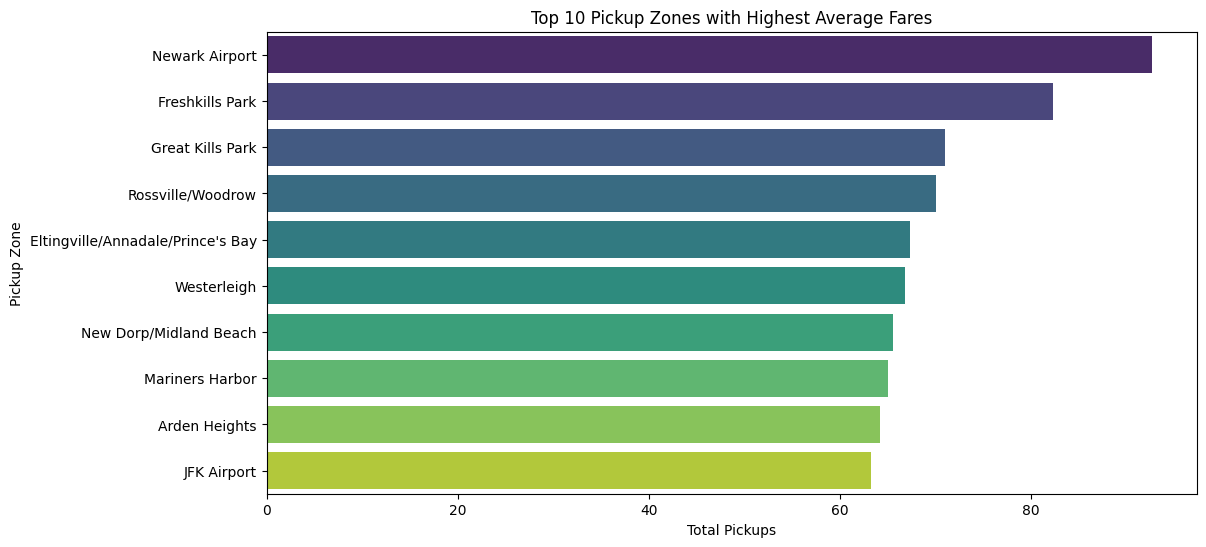

       total_pickups    avg_fare
count   2.590000e+02  259.000000
mean    1.449772e+05   32.909376
std     3.521148e+05   13.956080
min     1.000000e+00    9.387611
25%     8.410000e+02   24.028396
50%     2.422000e+03   30.727615
75%     2.148250e+04   39.591711
max     1.952656e+06   92.693403


In [11]:
# Plot top 10 pickup zones
top_fare_pickups_spots = fare_pickup_analysis.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_fare_pickups_spots, x='avg_fare', y='zone', palette='viridis')
plt.xlabel('Total Pickups')
plt.ylabel('Pickup Zone')
plt.title('Top 10 Pickup Zones with Highest Average Fares')
plt.show()

# Check if the pickup location influences total fare
print(pickup_analysis.describe())

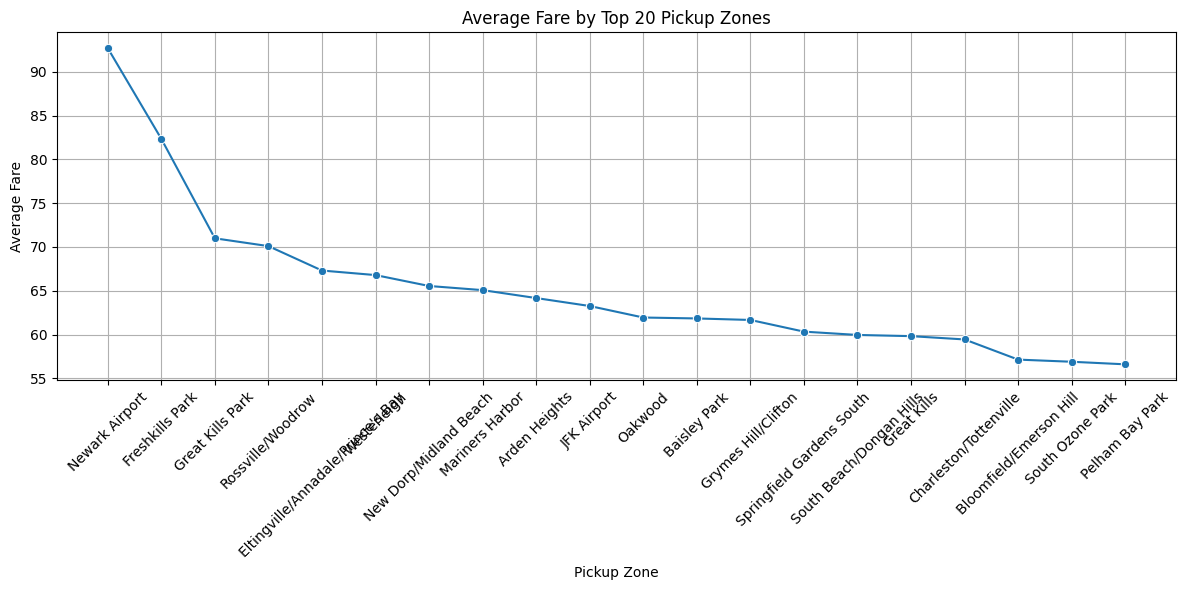

In [22]:
# Top 20 zones by average fare
top_zones = pickup_analysis.sort_values(by='avg_fare', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_zones, x='zone', y='avg_fare', marker='o')
plt.title('Average Fare by Top 20 Pickup Zones')
plt.xlabel('Pickup Zone')
plt.ylabel('Average Fare')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### **3. Insights**

1. **Pickup Location's Impact on Fares** (Does the Pickup Location Influence the Total Fare?):
   - **Correlation**: Pickup location (`zone`) significantly affects the total fare due to distance, time, and specific fees associated with certain zones (e.g., airports). Zones like **airports** (e.g., LaGuardia Airport, Newark Airport) and **high-demand urban centers** (e.g., Midtown Manhattan, Financial District) are consistently associated with higher fares.
   - **Key Factors**: Distance to the drop-off point, congestion charges, and special fees (e.g., airport surcharges) drive fare variations.

2. **Factors Driving Higher Fares**:
   - **Distance**: Longer trips from peripheral zones like airports to the city center naturally increase fares.
   - **Zone-Specific Fees**: Airport pickups include additional fees such as congestion surcharges or airport service charges.
   - **Demand**: Central business districts (e.g., Midtown) see higher demand, leading to higher base fares or surcharges during peak times.

3. **Zones with Highest Average Fares** (Which Pickup Locations Tend to Generate the Highest Fares?):
   - **Airport Zones**: Locations like *LaGuardia Airport* and *JFK Airport* dominate in average fares due to travel distances and airport-related surcharges.
   - **Commercial Areas**: Zones in boroughs like Manhattan (e.g., *Midtown* and *Financial District*) have high fares due to business-related travel, dense traffic, and higher likelihood of tips.
   - **Low-Population Areas**: Some outer zones with low pickup frequency but long travel distances also appear in the top zones.

4. **Borough Breakdown**:
   - **Manhattan**: Typically generates higher fares due to high demand and shorter, frequent business-related travel adding congestion charges.
   - **Queens**: Contains high-fare zones like *JFK Airport* and *LaGuardia Airport*, significantly raising average fares.
   - **Outer Boroughs (Bronx, Staten Island, Brooklyn)**: Lower average fares, except for trips originating from key transit hubs or far-off locations.

5. **Visual Confirmation**:
   - The bar chart highlights the dominance of airport and Manhattan zones. These zones align with the broader trend of high-demand and long-distance trips.

#### **Conclusion:**
Pickup location is a critical determinant of fare amounts. High-demand and long-distance zones such as airports and business districts dominate average fare metrics. Optimizing services in these high-yield zones could maximize revenue for taxi operators. Conversely, understanding fare patterns could help passengers anticipate costs more accurately.